In [1]:
from classy import Class
#%matplotlib inline
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

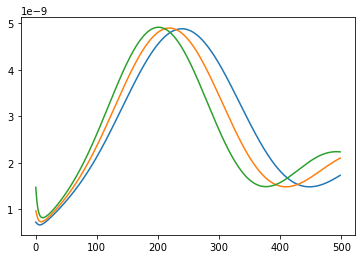

In [3]:
ells=[l*(l+1) for l in range(501)]
for h in [0.4,0.67,1.0]:
    # Define your cosmology (what is not specified will be set to CLASS default parameters)
    params = {
        'output': 'tCl lCl',
        'l_max_scalars': 2000,
        'lensing': 'yes',
        'A_s': 2.3e-9,
        'n_s': 0.9624, 
        #'h': 0.6711,
        'h': h,
        'omega_b': 0.022068,
        'omega_cdm': 0.12029}

    # Create an instance of the CLASS wrapper
    cosmo = Class()

    # Set the parameters to the cosmological code
    cosmo.set(params)

    # Run the whole code. Depending on your output, it will call the
    # CLASS modules more or less fast. For instance, without any
    # output asked, CLASS will only compute background quantities,
    # thus running almost instantaneously.
    # This is equivalent to the beginning of the `main` routine of CLASS,
    # with all the struct_init() methods called.
    cosmo.compute()

    # Access the lensed cl until l=2000
    cls = cosmo.lensed_cl(500)
    del(cosmo)
    #plt.figure()
    plt.plot((cls['tt']*ells)[2:])


In [4]:
import swyft

In [23]:
'''dumb simulator'''
def simulator(h, sigma=0.1): 
    return [h]*196608+sigma*np.random.rand(196608)


def model(params):
    """Model wrapper around simulator code."""
    mu = simulator(params["h"])
    return dict(mu=mu)

#noise from cosmic variance
def noise(obs, params=None, sigma=1.0):
    """Associated noise model."""
    data = {k: v for k, v in obs.items()}
    return data

In [15]:
prior = swyft.Prior({"h": ['uniform', 0.4,1.0]})

In [3]:
cache=swyft.DirectoryCache(params=['h'],obs_shapes={'h':[501]}, path='/var/scratch/aecole/cache.zarr')

NameError: name 'swyft' is not defined

In [135]:
cache.__len__()

20172

In [5]:
theMap=hp.sphtfunc.synfast(cls['tt'],nside=128)

/var/scratch/aecole/miniconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:433: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  warnings.warn(
/var/scratch/aecole/miniconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:822: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  warnings.warn(
/var/scratch/aecole/miniconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:827: UserWarning: -> fwhm is 0.000000 arcmin
  warnings.warn(


In [8]:
clsNoise=hp.sphtfunc.anafast(theMap)

In [13]:
clsNoise.shape

(384,)

In [28]:
conv1 = torch.nn.Conv1d(1, 10, 3)
conv2 = torch.nn.Conv1d(10, 20, 3)
conv3 = torch.nn.Conv1d(20, 40, 3)
pool = torch.nn.MaxPool1d(2)

In [29]:
y=torch.tensor(clsNoise,dtype=torch.float32)

In [30]:
y.unsqueeze(0).unsqueeze(1).shape

torch.Size([1, 1, 384])

In [31]:
with torch.no_grad():
    yy=conv1(y.unsqueeze(0).unsqueeze(1))
    yy=pool(yy)
    yy=conv2(yy)
    yy=pool(yy)
    yy=conv3(yy)
    yy=pool(yy)
print(yy.shape)

torch.Size([1, 40, 46])


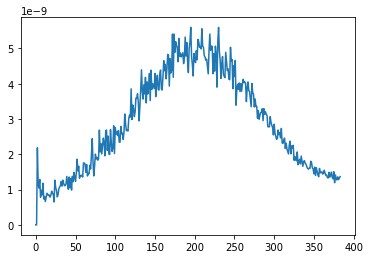

In [12]:
plt.plot(clsNoise*ells[:384])

In [33]:
10E9

10000000000.0

In [ ]:
hp.sphtfunc.anafast(cache[954]['x']['mu']).shape

In [153]:
print(cache[954]['z'],cache[955]['z'],cache[1111]['z'])

{'h': 0.4692871868610382} {'h': 0.6160193681716919} {'h': 0.8553240299224854}


In [166]:
hp.sphtfunc.map2alm(cache[954]['x']['mu'][hp.ring2nest(128,range(196608))])

TypeError: alm2map() missing 1 required positional argument: 'nside'

In [160]:
len(cache[954]['x']['mu'])

196608

In [163]:
cache[954]['x']['mu']

array([ 8.31665783e-06,  1.09884299e-05, -9.36838560e-06, ...,
        6.75923607e-05,  4.09572853e-05,  2.80562016e-05])

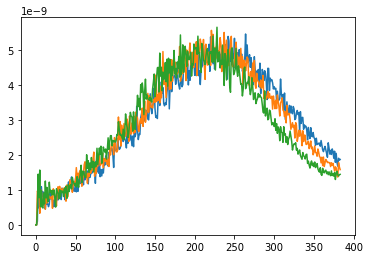

In [154]:
plt.plot(hp.sphtfunc.anafast(cache[954]['x']['mu'])*ells[:384]);
plt.plot(hp.sphtfunc.anafast(cache[955]['x']['mu'])*ells[:384]);
plt.plot(hp.sphtfunc.anafast(cache[1111]['x']['mu'])*ells[:384]);

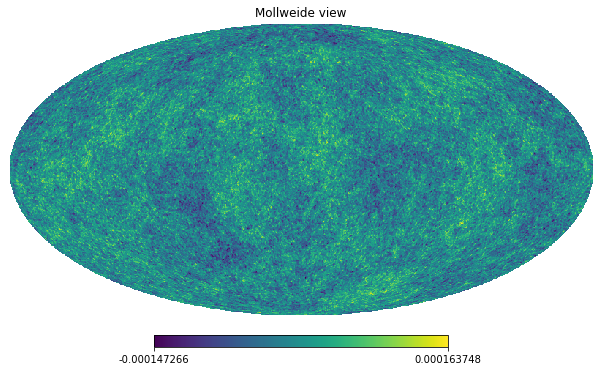

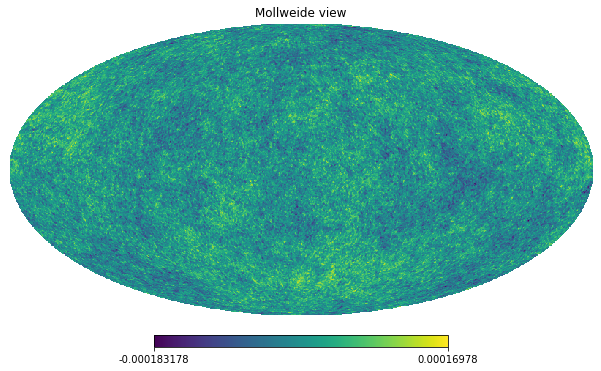

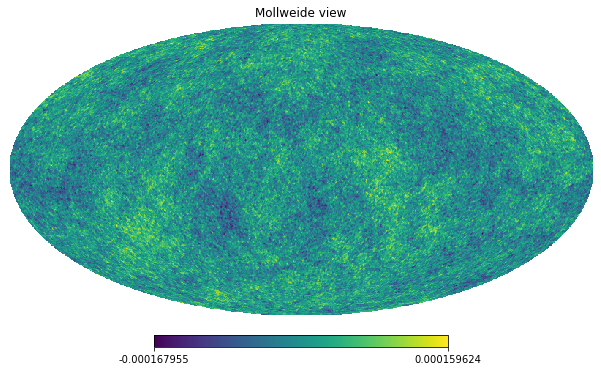

In [156]:
hp.mollview(cache[954]['x']['mu'])
hp.mollview(cache[955]['x']['mu'])
hp.mollview(cache[1111]['x']['mu'])

now define sphere layers

In [25]:
from deepsphere.layers.samplings.healpix_pool_unpool import Healpix
from deepsphere.layers.samplings.healpix_pool_unpool import HealpixMaxPool as hpmp
from deepsphere.layers.samplings.healpix_pool_unpool import HealpixMaxUnpool as hpmup
from deepsphere.layers.samplings.healpix_pool_unpool import HealpixAvgPool as hpap
from deepsphere.layers.samplings.healpix_pool_unpool import HealpixAvgUnpool as hpaup
from deepsphere.utils.laplacian_funcs import get_healpix_laplacians
from deepsphere.layers.chebyshev import SphericalChebConv

In [26]:
#bugfix for hpmp
import torch.nn.functional as F
class HealpixMaxPool(torch.nn.MaxPool1d):
    """Healpix Maxpooling module
    """

    def __init__(self, return_indices=False):
        """Initialization
        """
        super().__init__(kernel_size=4, return_indices=return_indices)

    def forward(self, x):
        """Forward call the 1d Maxpooling of pytorch

        Args:
            x (:obj:`torch.tensor`):[batch x pixels x features]

        Returns:
            tuple((:obj:`torch.tensor`), indices (int)): [batch x pooled pixels x features] and indices of pooled pixels
        """
        x = x.permute(0, 2, 1)
        if self.return_indices:
            x, indices = F.max_pool1d(x, self.kernel_size)
        else:
            x = F.max_pool1d(x,self.kernel_size)
        x = x.permute(0, 2, 1)

        if self.return_indices:
            output = x, indices
        else:
            output = x
        return output

In [28]:
x=[1]*(12*128**2)
y=torch.tensor(x,dtype=torch.float32)

In [29]:
y.unsqueeze(-1).shape

torch.Size([196608, 1])

In [30]:
y=y.unsqueeze(0).unsqueeze(-1)
print(y.shape)

torch.Size([1, 196608, 1])


In [31]:
from pygsp.graphs.nngraphs.spherehealpix import SphereHealpix
from deepsphere.utils.laplacian_funcs import prepare_laplacian

from deepsphere.utils.samplings import (
    healpix_resolution_calculator
)
def get_healpix_laplacians(nodes, depth, laplacian_type):
    """Get the healpix laplacian list for a certain depth.
    Args:
        nodes (int): initial number of nodes.
        depth (int): the depth of the UNet.
        laplacian_type ["combinatorial", "normalized"]: the type of the laplacian.
    Returns:
        laps (list): increasing list of laplacians.
    """
    laps = []
    for i in range(depth):
        pixel_num = nodes
        resolution = int(healpix_resolution_calculator(pixel_num)/2**i)
        G = SphereHealpix(nside=resolution, n_neighbors=8)
        G.compute_laplacian(laplacian_type)
        laplacian = prepare_laplacian(G.L)
        laps.append(laplacian)
    return laps[::-1]

In [108]:
laps=get_healpix_laplacians(12*128**2,7,"normalized")


In [105]:
laps[1:]

[tensor(indices=tensor([[  0,   0,   0,  ..., 767, 767, 767],
                        [  0,   1,   2,  ..., 765, 766, 767]]),
        values=tensor([ 0.3151, -0.2466, -0.2466,  ..., -0.2466, -0.2466,
                        0.3151]),
        size=(768, 768), nnz=7032, layout=torch.sparse_coo),
 tensor(indices=tensor([[   0,    0,    0,  ..., 3071, 3071, 3071],
                        [   0,    1,    2,  ..., 3069, 3070, 3071]]),
        values=tensor([ 0.2787, -0.2390, -0.2390,  ..., -0.2390, -0.2390,
                        0.2787]),
        size=(3072, 3072), nnz=27960, layout=torch.sparse_coo),
 tensor(indices=tensor([[    0,     0,     0,  ..., 12287, 12287, 12287],
                        [    0,     1,     2,  ..., 12285, 12286, 12287]]),
        values=tensor([ 0.2595, -0.2352, -0.2352,  ..., -0.2352, -0.2352,
                        0.2595]),
        size=(12288, 12288), nnz=111608, layout=torch.sparse_coo),
 tensor(indices=tensor([[    0,     0,     0,  ..., 49151, 49151, 4915

In [109]:
spch1 = SphericalChebConv(1, 10, laps[-1], kernel_size=3)
spch2 = SphericalChebConv(10, 20, laps[-2], kernel_size=3)
spch3 = SphericalChebConv(20, 40, laps[-3], kernel_size=3)
spch4 = SphericalChebConv(40, 80, laps[-4], kernel_size=3)
spch5 = SphericalChebConv(80, 160, laps[-5], kernel_size=3)
spch6 = SphericalChebConv(160, 320, laps[-6], kernel_size=3)
spch7 = SphericalChebConv(320, 640, laps[-7], kernel_size=3)
pool = HealpixMaxPool()
#pool=hpap()

In [110]:
with torch.no_grad():
    yy=spch1(y)
    yy=pool(yy)
    yy=spch2(yy)
    yy=pool(yy)
    yy=spch3(yy)
    yy=pool(yy)
    yy=spch4(yy)
    yy=pool(yy)
    yy=spch5(yy)
    yy=pool(yy)
    yy=spch6(yy)
    yy=pool(yy)
    yy=spch7(yy)
    yy=pool(yy)
    zz=torch.softmax(yy,dim=1)

In [111]:
yy.shape

torch.Size([1, 12, 640])

In [112]:
y.shape

torch.Size([1, 196608, 1])

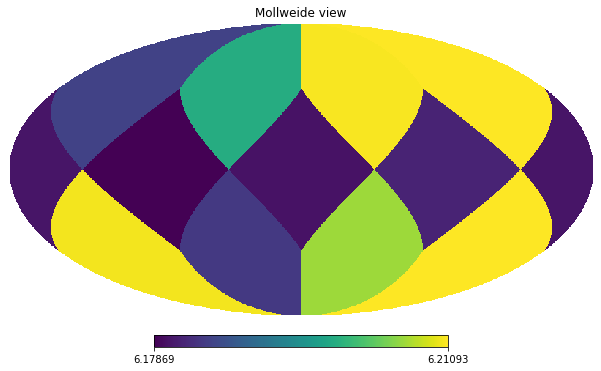

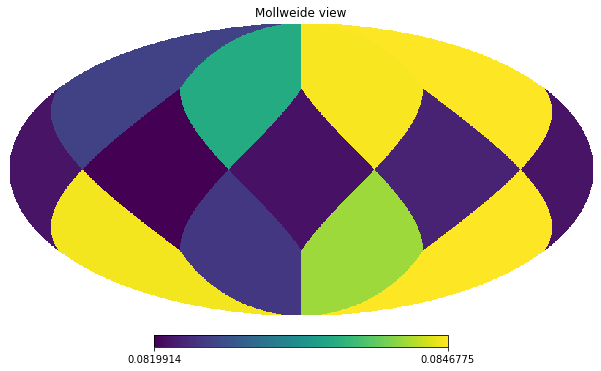

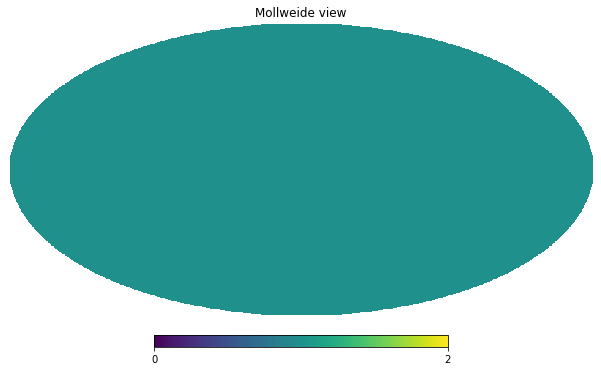

In [114]:
hp.mollview(yy[0,:,0])
hp.mollview(zz[0,:,0])
hp.mollview(y[0,:,0])

In [123]:
from deepsphere.layers.chebyshev import ChebConv
NSIDE=128
laps=get_healpix_laplacians(12*NSIDE**2,7,"normalized")
llaps1=laps[-1].cuda()
llaps2=laps[-2].cuda()
llaps3=laps[-3].cuda()
llaps4=laps[-4].cuda()
llaps5=laps[-5].cuda()
llaps6=laps[-6].cuda()
llaps7=laps[-7].cuda()

class CustomHead(swyft.Module):
    def __init__(self, obs_shapes):
        super().__init__(obs_shapes=obs_shapes)

        self.n_features = 12*640

        #self.spch1 = SphericalChebConv(1, 10, laps[-1], kernel_size=3)
        #self.spch2 = SphericalChebConv(10, 20, laps[-2], kernel_size=3)
        #self.spch3 = SphericalChebConv(20, 40, laps[-3], kernel_size=3)
        self.spch1 = ChebConv(1, 10, kernel_size=5)
        self.spch2 = ChebConv(10, 20, kernel_size=5)
        self.spch3 = ChebConv(20, 40, kernel_size=5)
        self.spch4 = ChebConv(40, 80, kernel_size=5)
        self.spch5 = ChebConv(80, 160, kernel_size=5)
        self.spch6 = ChebConv(160, 320, kernel_size=5)
        self.spch7 = ChebConv(320, 640, kernel_size=5)
        self.pool = HealpixMaxPool()
        #self.l = torch.nn.Linear(192*40, 1000)
        #self.onl_f = OnlineNormalizationLayer(torch.Size([196608]))

    def forward(self, obs):
        '''input has shape [n_batch, n_pixel]
            which we map to [n_batch, n_pixel, n_channel=1] before entering the convolutional/pooling layers
            at the end we output a shape [n_batch, n_features]
        '''
        x = obs["mu"]
        nbatch = len(x)
        #x = torch.log(0.1+x)
        #x=self.onl_f(x)
        x=x.unsqueeze(-1)

        x = self.spch1(llaps1,x)
        x = self.pool(x)
        x = self.spch2(llaps2,x)
        x = self.pool(x)
        x = self.spch3(llaps3,x)
        x = self.pool(x)
        x = self.spch4(llaps4,x)
        x = self.pool(x)
        x = self.spch5(llaps5,x)
        x = self.pool(x)
        x = self.spch6(llaps6,x)
        x = self.pool(x)
        x = self.spch7(llaps7,x)
        x = self.pool(x)
        x=torch.softmax(x,dim=1)
        x = x.view(nbatch, -1)
        #x = self.l(x)

        return x

In [118]:
prior

In [120]:
obs0=model({'h':0.67})

In [124]:
s = swyft.NestedRatios(
        model,
        prior,
        noise=noise,
        obs=obs0,
        device='cuda:0',
        Ninit=3000,
        Nmax=100000,
        cache=cache,
    )

In [126]:
import logging

logging.basicConfig(level=logging.DEBUG, format="%(message)s")

In [128]:
s.run(
        max_rounds=10,
        train_args={'lr_schedule': [1e-3,1e-4]},
        head=CustomHead,
        #head=defs.HeadCl,
        tail_args={},
        head_args={},
    )

In [130]:
samples = s.marginals(obs0, 30000)

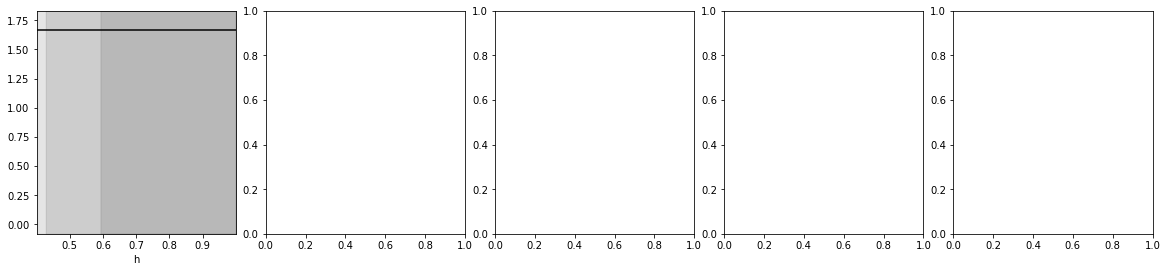

In [132]:
swyft.plot.plot1d(
        samples,
        list(prior.params()),
        figsize=(20, 4),
        ncol=5,
        grid_interpolate=True,
        #truth=par0,
    )

In [133]:
torch.cuda.empty_cache()